In [315]:
import numpy as np
import networkx as nx
import pandas as pd

from tqdm import tqdm
from itertools import combinations
from scipy import stats
from sklearn import decomposition, preprocessing, manifold
from collections import defaultdict

from news_vec.utils import read_json_gz_lines

In [2]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import altair as alt
import seaborn as sns

mpl.style.use('seaborn-muted')
sns.set(style="whitegrid")

In [3]:
df = pd.DataFrame(list(tqdm(read_json_gz_lines('../../data/clf-acc-ts-ob.json/'))))

955500it [00:02, 402048.00it/s]


In [4]:
d1s, d2s = zip(*df[['d1', 'd2']].apply(lambda x: sorted(x), 1))
df.drop(['d1', 'd2'], 1)
df['d1'] = d1s
df['d2'] = d2s

In [5]:
pairs = set(map(tuple, df[['d1', 'd2']].values.tolist()))

In [6]:
rows = []
for d1, d2 in tqdm(pairs):
    pdf = df[(df.d1==d1)&(df.d2==d2)].sort_values('window')
    lr = stats.linregress(pdf.window, pdf.acc)
    rows.append((d1, d2, lr.slope, lr.pvalue, lr.rvalue))

100%|██████████| 105/105 [00:20<00:00,  4.85it/s]


In [7]:
lr_df = pd.DataFrame(rows, columns=('d1', 'd2', 'slope', 'p', 'r'))

In [376]:
def plot_pair(d1, d2):
    pdf = df[(df.d1==d1)&(df.d2==d2)].sort_values('window')
    plt.figure(figsize=(8,3))
    sns.boxplot(x='window', y='acc', data=pdf)
    plt.show()

buzzfeed.com huffingtonpost.com


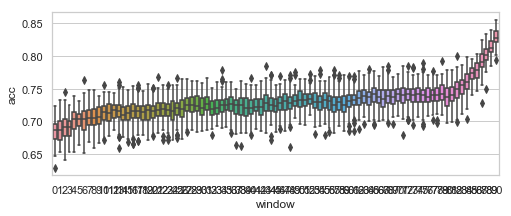

buzzfeed.com foxnews.com


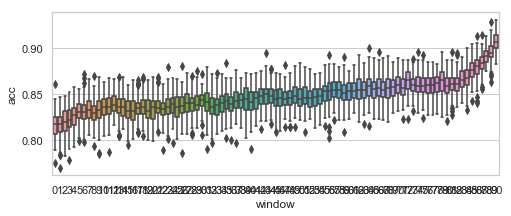

foxnews.com wsj.com


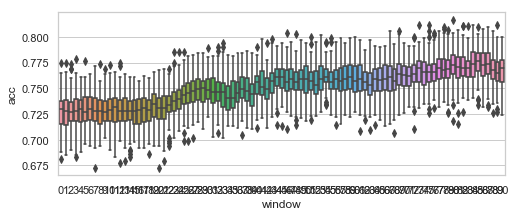

foxnews.com washingtonpost.com


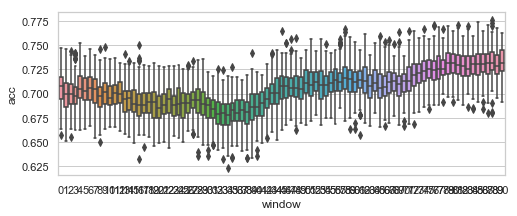

cnn.com foxnews.com


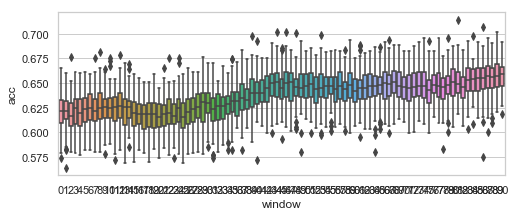

apnews.com buzzfeed.com


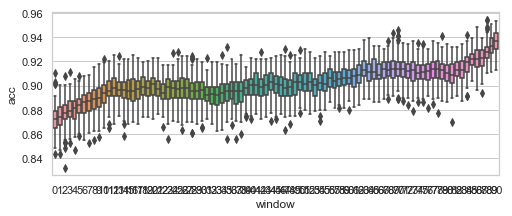

breitbart.com buzzfeed.com


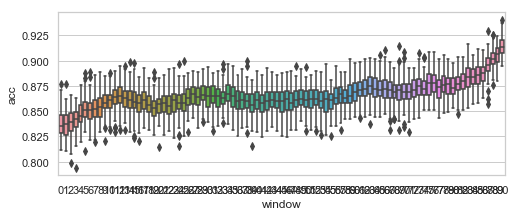

apnews.com foxnews.com


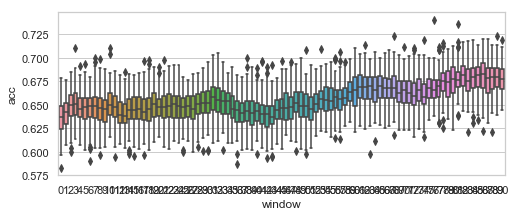

foxnews.com nytimes.com


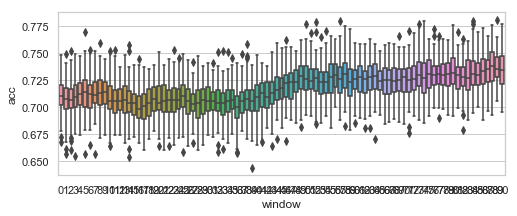

breitbart.com foxnews.com


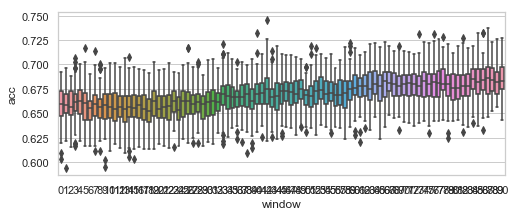

In [43]:
for r in lr_df.sort_values('slope', ascending=False).head(10).itertuples():
    print(r.d1, r.d2)
    plot_pair(r.d1, r.d2)

huffingtonpost.com thehill.com


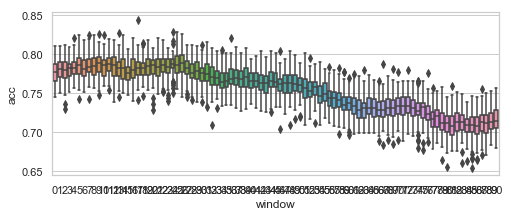

dailykos.com huffingtonpost.com


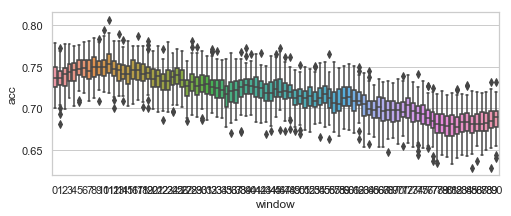

cnn.com huffingtonpost.com


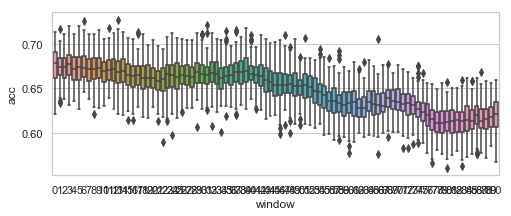

cnn.com dailykos.com


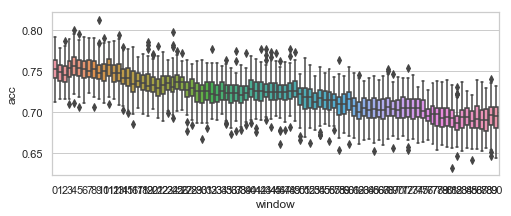

dailykos.com thehill.com


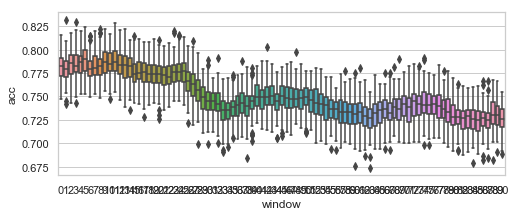

apnews.com thehill.com


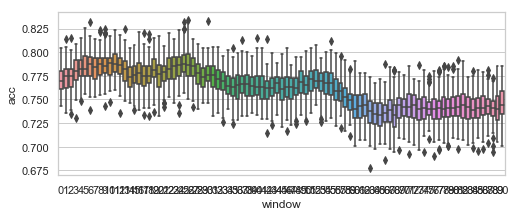

dailykos.com washingtonpost.com


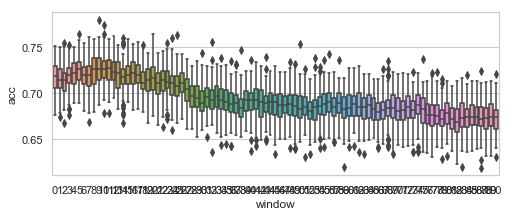

dailykos.com nytimes.com


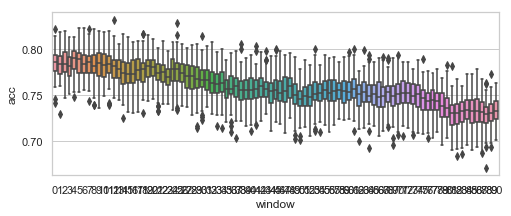

dailykos.com npr.org


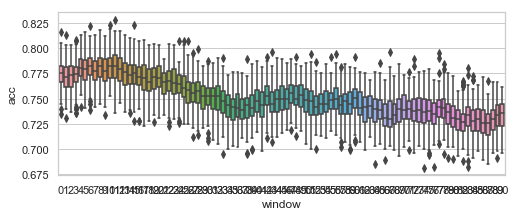

npr.org thehill.com


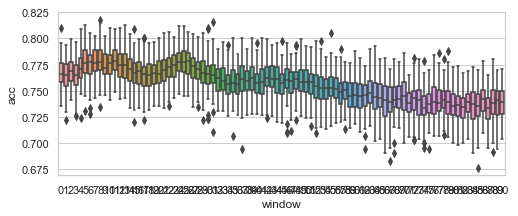

In [44]:
for r in lr_df.sort_values('slope', ascending=True).head(10).itertuples():
    print(r.d1, r.d2)
    plot_pair(r.d1, r.d2)

In [415]:
lr_df['label'] = lr_df[['d1', 'd2']].apply(lambda x: f'{x[0]} - {x[1]}', axis=1)

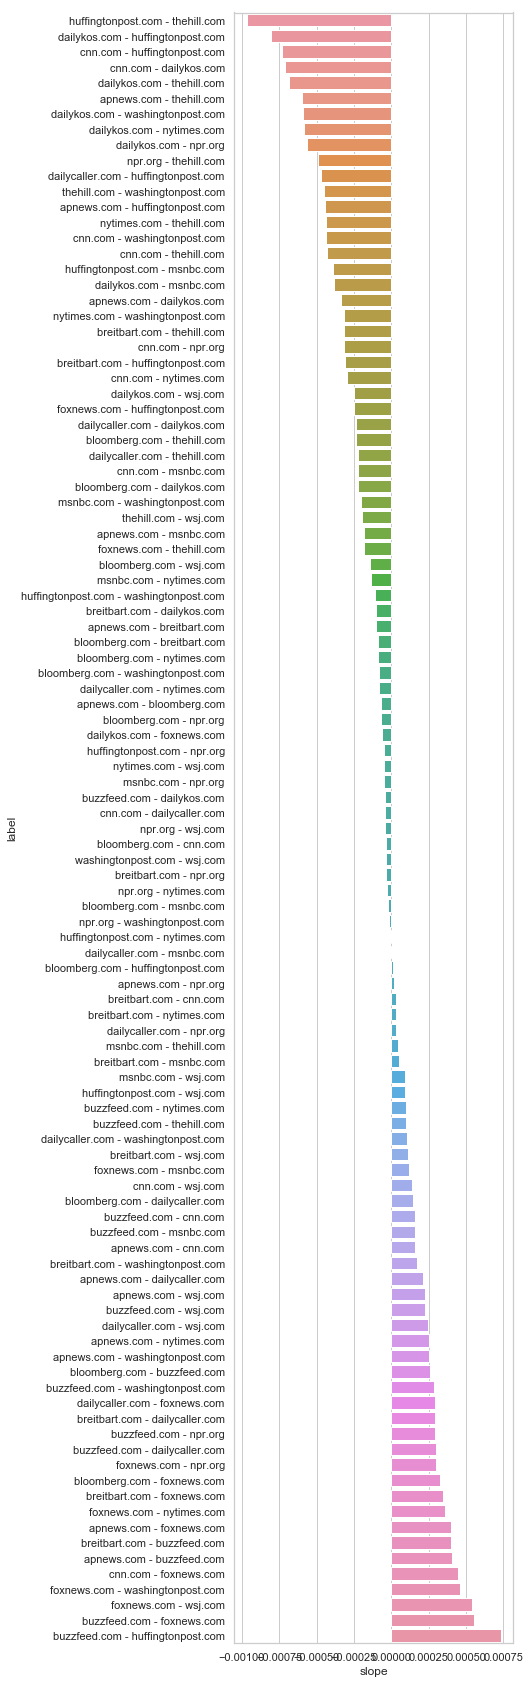

In [418]:
plt.figure(figsize=(5,30))
sns.barplot(x='slope', y='label', data=lr_df.sort_values('slope'))

In [530]:
lr_df['color'] = lr_df.slope.apply(lambda s: 'red' if s > 0 else 'blue')
lr_df['width'] = abs(lr_df.slope*3000)**2

In [531]:
g = nx.Graph()
for r in lr_df.itertuples():
    g.add_edge(r.d1, r.d2, width=r.width, color=r.color)

In [532]:
edge_width = [d['width'] for _, _, d in g.edges(data=True)]
edge_color = [d['color'] for _, _, d in g.edges(data=True)]

/Users/dclure/.local/share/virtualenvs/news-vec-AvAtlVxK/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


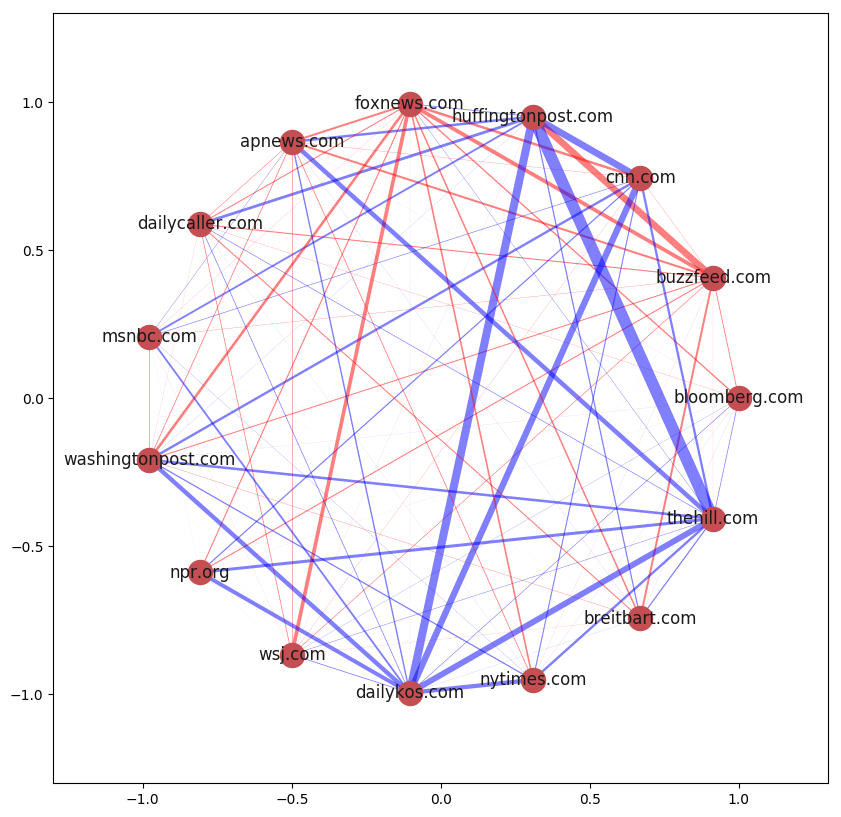

In [542]:
mpl.style.use('seaborn-muted')
plt.figure(figsize=(10,10))
plt.xlim(-1.3,1.3)
plt.ylim(-1.3,1.3)
pos = nx.layout.circular_layout(g)
nx.draw_networkx_nodes(g, pos)
nx.draw_networkx_edges(g, pos, edge_color=edge_color, width=edge_width, alpha=0.5)
_ = nx.draw_networkx_labels(g, pos)